In [1]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d brsdincer/pulsar-classification-for-class-prediction
!unzip /content/pulsar-classification-for-class-prediction.zip

  0% 0.00/771k [00:00<?, ?B/s]
100% 771k/771k [00:00<00:00, 130MB/s]
Archive:  /content/pulsar-classification-for-class-prediction.zip
  inflating: Pulsar.csv              


###**Importación Librerías**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### **EDA + Data Prep**

In [7]:
df = pd.read_csv('/content/Pulsar.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Mean_Integrated       17898 non-null  float64
 1   SD                    17898 non-null  float64
 2   EK                    17898 non-null  float64
 3   Skewness              17898 non-null  float64
 4   Mean_DMSNR_Curve      17898 non-null  float64
 5   SD_DMSNR_Curve        17898 non-null  float64
 6   EK_DMSNR_Curve        17898 non-null  float64
 7   Skewness_DMSNR_Curve  17898 non-null  float64
 8   Class                 17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [8]:
df.head()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [9]:
df.describe(percentiles=[.25, .5, .75, .85, .90,.95]).T

,count,mean,std,min,25%,50%,75%,85%,90%,95%,max
Mean_Integrated,17898.0,111.079968,25.652935,5.812500,100.929688,115.078125,127.085938,133.249219,137.236719,143.072656,192.617188
SD,17898.0,46.549532,6.843189,24.772042,42.376018,46.947479,51.023202,52.968065,54.412099,56.473756,98.778911
EK,17898.0,0.477857,1.064040,-1.876011,0.027098,0.223240,0.473325,0.665355,0.891816,2.706561,8.069522
Skewness,17898.0,1.770279,6.167913,-1.791886,-0.188572,0.198710,0.927783,1.780180,2.765966,10.138507,68.101622
Mean_DMSNR_Curve,17898.0,12.614400,29.472897,0.213211,1.923077,2.801839,5.464256,12.981564,30.573495,82.966973,223.392141
SD_DMSNR_Curve,17898.0,26.326515,19.470572,7.370432,14.437332,18.461316,28.428104,43.679494,59.080452,74.621642,110.642211
EK_DMSNR_Curve,17898.0,8.303556,4.506092,-3.139270,5.781506,8.433515,10.702959,12.194457,13.466038,15.770680,34.539844
Skewness_DMSNR_Curve,17898.0,104.857709,106.514540,-1.976976,34.960504,83.064556,139.309330,182.002828,220.351313,296.379055,1191.000837
Class,17898.0,0.091574,0.288432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
def nan_checking(dataframe):
    # Calcula el número de valores nulos en cada columna
    nulos_por_columna = dataframe.isnull().sum()
    # Crea un DataFrame que muestre la cantidad de nulos por columna
    tabla = pd.DataFrame({'Columna': nulos_por_columna.index, 'Nulos': nulos_por_columna.values})
    # Ordena la tabla de manera descendente por la cantidad de nulos
    tabla = tabla.sort_values(by='Nulos', ascending=False)

    return tabla

In [11]:
nan_checking(df)

,Columna,Nulos
0,Mean_Integrated,0
1,SD,0
2,EK,0
3,Skewness,0
4,Mean_DMSNR_Curve,0
5,SD_DMSNR_Curve,0
6,EK_DMSNR_Curve,0
7,Skewness_DMSNR_Curve,0
8,Class,0


In [12]:
def plot_kde(dataframe, num_rows, num_cols):
    """
    Crea gráficos KDE para las columnas especificadas en un DataFrame y los distribuye en filas y columnas.

    Args:
    dataframe (pd.DataFrame): El DataFrame que contiene los datos.
    columns (list): Lista de nombres de columnas para las cuales se generarán los gráficos KDE.
    num_rows (int): Número de filas para la disposición de subgráficos.
    num_cols (int): Número de columnas para la disposición de subgráficos.

    Returns:
    None
    """
    # Calcula el número total de subgráficos
    num_plots = len(dataframe.columns)

    # Calcula el número de filas y columnas según los parámetros o de forma automática si no se proporcionan
    if num_rows is None or num_cols is None:
        num_cols = int(math.ceil(num_plots ** 0.5))
        num_rows = int(math.ceil(num_plots / num_cols))

    # Verifica que el número total de subgráficos no sea mayor que el número de subplots disponibles
    if num_plots > num_rows * num_cols:
        print(f"El número de subgráficos ({num_plots}) es mayor que el número de subplots disponibles ({num_rows}x{num_cols}).")
        return

    # Crea subplots para organizar los gráficos en filas y columnas
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 6))
    axs = axs.flatten()  # Convierte la matriz de subplots en una lista unidimensional

    # Itera a través de las columnas y crea los gráficos KDE correspondientes
    for i, column in enumerate(dataframe.columns):
        ax = axs[i]
        sns.kdeplot(data=dataframe[column], ax=ax, color='blue', alpha=0.4, fill=True, common_norm=False)
        ax.set_title(f"{column}")
        #ax.legend()

    # Ajusta la disposición de los subplots
    plt.tight_layout()
    plt.show()

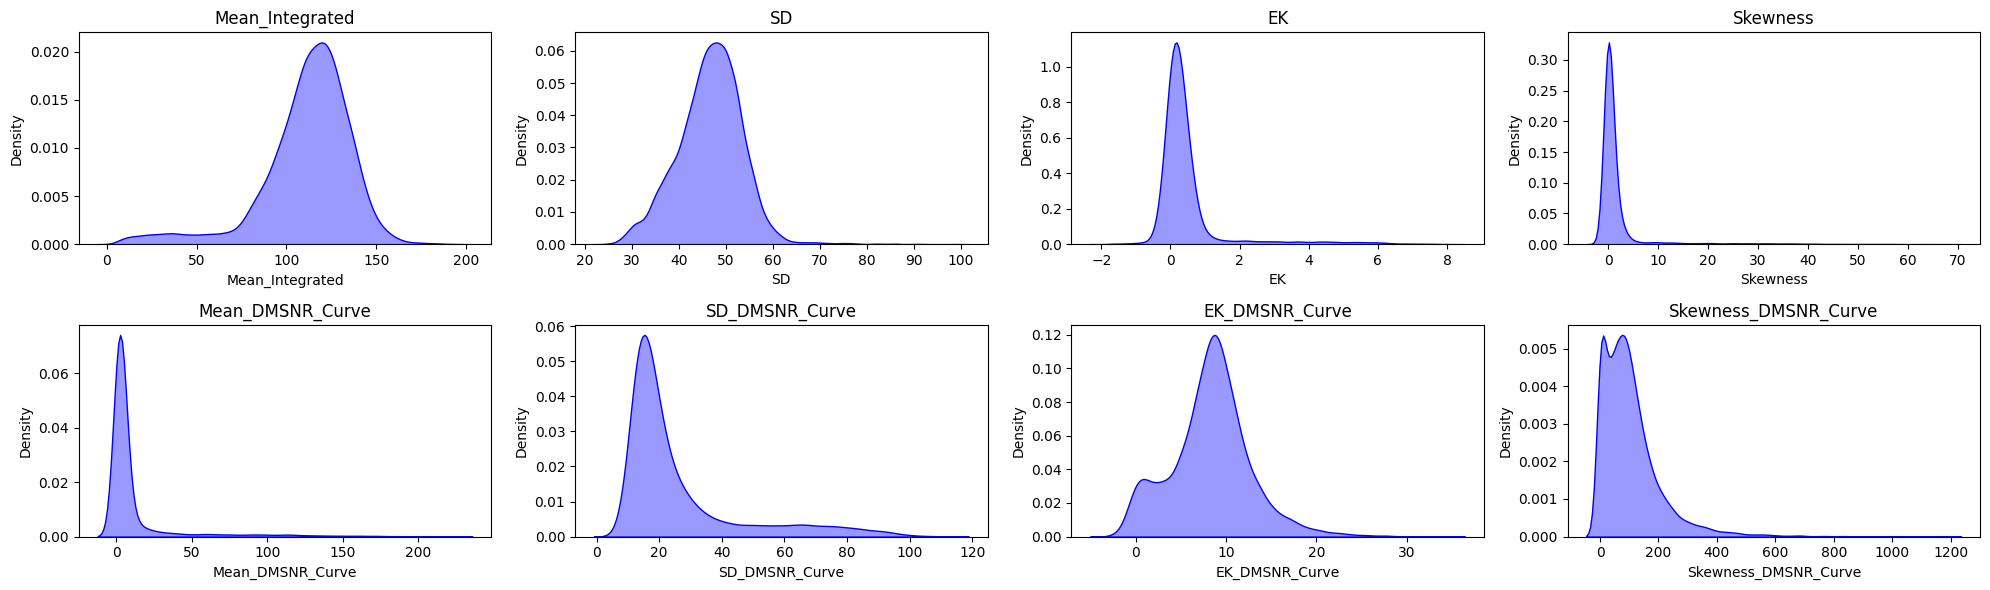

In [13]:
plot_kde(df.iloc[:, :8], 2, 4)

In [14]:
def plot_categorical(column, title_name=None):
    """
    Genera gráficos de barras y de torta para una columna categórica.

    Args:
    column (pd.Series): La columna categórica que se desea visualizar.
    title_name (str): El nombre del conjunto de datos (por defecto es 'Dataset').

    Returns:
    None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.subplots_adjust(wspace=0.4)

    # Gráfico de Barras
    sns.countplot(data=df, x=column, ax=axs[0])
    axs[0].set_title(f'Bar Plot para "{column.name}"')
    axs[0].set_xlabel(column.name)
    axs[0].set_ylabel('Count')
    axs[0].set_ylim(0, len(df))  # Ajusta los límites del eje y para mostrar ambas categorías

    # Gráfico de Torta
    counts = column.value_counts()
    labels = counts.index
    axs[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axs[1].set_title(f'Pie Chart para "{column.name}"')

    axs[1].legend(loc='upper right', labels=labels)

    plt.suptitle(f'{title_name} - Gráficos Categóricos', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

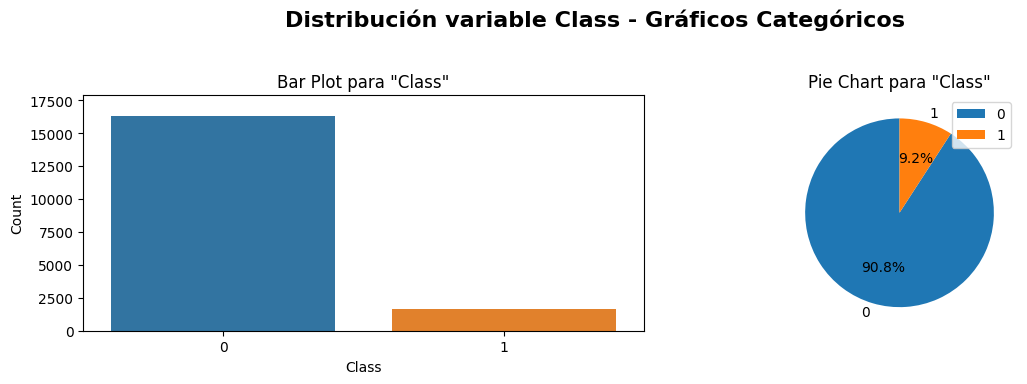

In [15]:
plot_categorical(df['Class'], title_name='Distribución variable Class')

In [16]:
def plot_correlation_heatmap(dataframe, title='Matriz de Correlación'):
    """
    Genera y muestra una matriz de correlación como un mapa de calor.

    Args:
    dataframe (pd.DataFrame): El DataFrame que contiene los datos.
    title (str): El título del gráfico (por defecto es 'Matriz de Correlación').

    Returns:
    None
    """
    # Calcula la matriz de correlación
    corr_matrix = dataframe.corr()

    # Crear una máscara para la mitad superior de la matriz
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Crea una figura y un eje para el mapa de calor
    plt.figure(figsize=(10, 8))

    # Genera el mapa de calor
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, mask = mask)

    # Establece el título
    plt.title(title, fontsize=16)

    # Muestra el gráfico
    plt.show()

    return corr_matrix

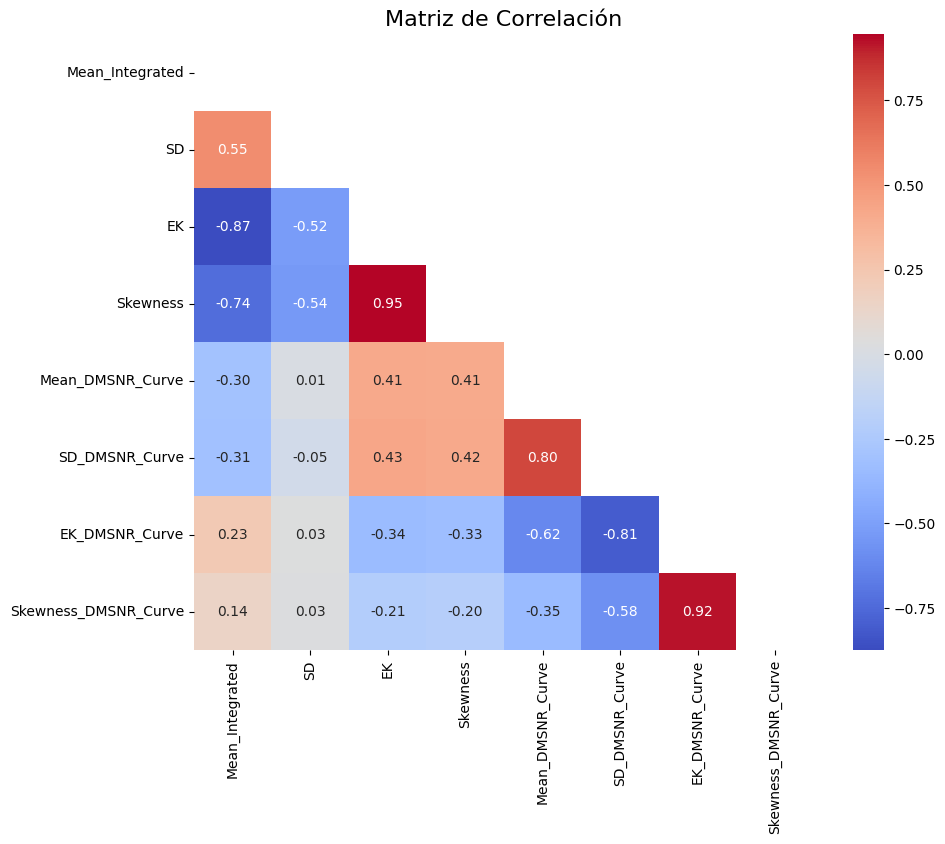

In [17]:
correlation_matrix = plot_correlation_heatmap(df.iloc[:, :8], title='Matriz de Correlación')

### **Train - Test Split con todas las variables**

In [18]:
X = df.drop('Class', axis=1)
y = df['Class']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size=0.3, random_state=101)

In [20]:
df_test = pd.concat([pd.DataFrame(X_test, columns=X.columns), pd.Series(y_test, name='target')], axis=1)
df_test.to_csv('test_data.csv', index=False)

In [21]:
def evaluate_models(models, X, y, cv=5):
    """
    Evalúa diferentes modelos utilizando validación cruzada.

    Args:
    models (list of tuples): Lista de tuplas donde cada tupla contiene el nombre del modelo y el modelo.
    X (pd.DataFrame): Conjunto de características.
    y (pd.Series): Variable objetivo.
    cv (int): Número de divisiones en la validación cruzada (por defecto es 5).

    Returns:
    pd.DataFrame: Un DataFrame que muestra F1-Score y Recall para cada modelo.
    """
    results = []

    for model_name, model in models:
        # Calcula F1-Score y Recall utilizando validación cruzada
        f1_scorer = make_scorer(f1_score)
        recall_scorer = make_scorer(recall_score)

        f1_scores = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
        recall_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)

        # Calcula la media de los puntajes
        mean_f1 = f1_scores.mean()
        mean_recall = recall_scores.mean()

        # Agrega los resultados a la lista
        results.append({
            'Modelo': model_name,
            'F1-Score Promedio': mean_f1,
            'Recall Promedio': mean_recall
        })

    # Crea un DataFrame a partir de los resultados
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by = 'Recall Promedio', ascending = False)

    return results_df

In [22]:
models = [
    ('Logistic Regression Baseline', LogisticRegression(random_state=42, max_iter=1000)),
    ('Logistic Regression Hiperparametros', LogisticRegression(C=1.0, penalty='l2', random_state=1, max_iter=1000, solver="newton-cg")),
    ('Logistic Regression Hiperparametros + Balanced', LogisticRegression(C=1.0, penalty='l2', random_state=1, max_iter=1000,solver="newton-cg", class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=1)),
    ('Random Forest Hiperparametros', RandomForestClassifier(random_state=1, n_estimators=100, max_depth=10))
    ]

# Llama a la función para evaluar los modelos
evaluate_models(models, X_train, y_train)

,Modelo,F1-Score Promedio,Recall Promedio
2,Logistic Regression Hiperparametros + Balanced,0.838200,0.911819
3,Random Forest,0.877909,0.834775
4,Random Forest Hiperparametros,0.879080,0.832207
0,Logistic Regression Baseline,0.873191,0.815058
1,Logistic Regression Hiperparametros,0.873191,0.815058


### **Testeo del mejor modelo**

In [23]:
best_model = LogisticRegression(C=1.0, penalty='l2', random_state=1, max_iter=1000
                                ,solver="newton-cg", class_weight='balanced')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [24]:
report = classification_report(y_test, y_pred, output_dict=True)

# Convierte el informe en un DataFrame
df_classification_report = pd.DataFrame(report).transpose()

# Muestra el DataFrame
df_classification_report

,precision,recall,f1-score,support
0,0.992111,0.975505,0.983738,4899.000000
1,0.783002,0.919321,0.845703,471.000000
accuracy,0.970577,0.970577,0.970577,0.970577
macro avg,0.887557,0.947413,0.914721,5370.000000
weighted avg,0.973770,0.970577,0.971631,5370.000000


In [25]:
import pickle

def save_model_to_pickle(model, file_path):
    """
    Guarda un modelo entrenado en un archivo pickle.

    Args:
    model: El modelo entrenado que deseas guardar.
    file_path (str): La ruta del archivo pickle donde deseas guardar el modelo.

    Returns:
    None
    """
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)

In [26]:
save_model_to_pickle(best_model, 'logreg_balanced.pkl')